<a href="https://colab.research.google.com/github/raj-vijay/mv/blob/master/09_Lab_8_Stitching_Image_Panorama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BACKGROUND**

<p align = 'justify'>In Lecture 8 we looked at estimating homographies between images that have been taken by a rotating camera. In this lab you will write a program to process a video sequence, track the features, and create an image panorama forselected frames. You will need to adapt and extend the KLT feature tracking of Lab06 to process the video courtyard.mp4 available on Canvas.</p>

**Task 1**

<p align = 'justify'>Adapt your KLT tracking implementation from the previous Lab06 to track features across the whole image sequence of the file courtyard.mp4. Make sure that there is sufficient feature overlap between the first and the middle as well as the last and the middle frame of the sequence.</p>

**Task 2**

<p align = 'justify'>Use the extracted feature tracks to estimate the homographies between the first and the middle as well as between the last and the middle frame using the Direct Linear Transformation (DLT) algorithm. Be careful to use consistent image coordinate systems (cv2.goodFeaturesToTrack() and cv2.calcOpticalFlowPyrLK() use x,y image coordinates, while the underlying numpy arrays use row,col coordinate systems; the easiest is to swap x,y coordinates at this point and work with row, col from here on).</p>

**Task 3**

<p align = 'justify'>Use the homographies calculated in task 2 to determine the coordinates of the corners of the first and the last frame when transformed into the coordinate system of the middle image. Create a target image that is sufficiently large to contain all three images transformed into the coordinate system of the middle image.</p>

**Task 4**

<p align = 'justify'>Extract the first, middle, and last image from the image sequence. For each pixel of the target image created in task 3 determine the coordinates in the first, middle, and last frame of the sequence using the homographies calculated in task 2. If any of these coordinates falls within the respective image, copy the colour value into the target image. Use nearest neighbour interpolation for simplicity. Save the resulting target image.</p>

In [ ]:
import cv2
import numpy as np

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def get_tracks(filename):
    camera = cv2.VideoCapture(filename)

    # initialise features to track
    while camera.isOpened():
        ret,img= camera.read()        
        if ret:
            new_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        
            p0 = cv2.goodFeaturesToTrack(new_img, 200, 0.3, 7)                                    
            break    

    # initialise tracks
    index = np.arange(len(p0))
    tracks = {}
    for i in range(len(p0)):
        tracks[index[i]] = {0:p0[i]}
                
    frame = 0
    while camera.isOpened():
        ret,img= camera.read()                 
        if not ret:
            break

        frame += 1

        old_img = new_img
        new_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        

        # calculate optical flow
        if len(p0)>0: 
            p1, st, err  = cv2.calcOpticalFlowPyrLK(old_img, new_img, p0, None)                                    
            
            # visualise points
            for i in range(len(st)):
                if st[i]:
                    cv2.circle(img, (int(p1[i,0,0]),int(p1[i,0,1])), 2, (0,0,255), 2)
                    cv2.line(img, (int(p0[i,0,0]),int(p0[i,0,1])), (int(p0[i,0,0]+(p1[i][0,0]-p0[i,0,0])*5),int(p0[i,0,1]+(p1[i][0,1]-p0[i,0,1])*5)), (0,0,255), 2)            
            
            p0 = p1[st==1].reshape(-1,1,2)            
            index = index[st.flatten()==1]
                
            
        # refresh features, if too many lost
        if len(p0)<100:
            new_p0 = cv2.goodFeaturesToTrack(new_img, 200-len(p0), 0.3, 7)
            for i in range(len(new_p0)):
                if np.min(np.linalg.norm((p0 - new_p0[i]).reshape(len(p0),2),axis=1))>10:
                    p0 = np.append(p0,new_p0[i].reshape(-1,1,2),axis=0)
                    index = np.append(index,np.max(index)+1)

        # update tracks
        for i in range(len(p0)):
            if index[i] in tracks:
                tracks[index[i]][frame] = p0[i]
            else:
                tracks[index[i]] = {frame: p0[i]}

        # visualise last frames of active tracks
        for i in range(len(index)):
            for f in range(frame-20,frame):
                if (f in tracks[index[i]]) and (f+1 in tracks[index[i]]):
                    cv2.line(img,
                             (int(tracks[index[i]][f][0,0]),int(tracks[index[i]][f][0,1])),
                             (int(tracks[index[i]][f+1][0,0]),int(tracks[index[i]][f+1][0,1])), 
                             (0,255,0), 1)

        # cut tracks that are too long
        # for i in tracks:
        #     if len(tracks[i])>50:
        #         keys = list(tracks[i].keys())
        #         for j in keys:
        #             if j<=max(keys)-50:
        #                 del tracks[i][j]
        

    camera.release()
        
    return tracks, frame

In [ ]:
def skew(x):
    return np.array([[0,-x[2],x[1]],
                     [x[2],0,-x[0]],
                     [-x[1],x[0],0]])

In [ ]:
def calculate_homography(tracks, frame1, frame2):
    correspondences = []
    for track in tracks:
        if (frame1 in tracks[track]) and (frame2 in tracks[track]):
            x1 = [tracks[track][frame1][0,1],tracks[track][frame1][0,0],1]
            x2 = [tracks[track][frame2][0,1],tracks[track][frame2][0,0],1]
            correspondences.append((np.array(x1), np.array(x2)))
        
    A = np.zeros((0,9))
    for x1,x2 in correspondences:
        Ai = np.kron(x1.T,skew(x2))
        Ai = Ai[[0,1],:]
        Ai = Ai / np.sqrt(np.sum(Ai.flatten()**2))
        A = np.append(A,Ai,axis=0)
        
    U,S,V = np.linalg.svd(A)    
    H = V[8,:].reshape(3,3).T
    
    return H

In [ ]:
def extract_frames(filename, frames):
    result = {}
    camera = cv2.VideoCapture(filename)
    last_frame = max(frames)
    frame=0
    while camera.isOpened():
        ret,img= camera.read()        
        if not ret:
            break
        if frame in frames:
            result[frame] = img        
        frame += 1
        if frame>last_frame:
            break

    return result

In [ ]:
def stitch_together(base_image, images_to_stitch):
    corners = np.array([[0,0,1],[base_image.shape[0],base_image.shape[1],1]])
    for image_to_stitch in images_to_stitch:   
        H = image_to_stitch[0]
        Hinv = np.linalg.inv(H)    
        x1 = np.matmul(Hinv,[0,0,1])
        x1 = x1/x1[2]
        x2 = np.matmul(Hinv,[image_to_stitch[1].shape[0],0,1])
        x2 = x2/x2[2]
        x3 = np.matmul(Hinv,[0,image_to_stitch[1].shape[1],1])
        x3 = x3/x3[2]
        x4 = np.matmul(Hinv,[image_to_stitch[1].shape[0],image_to_stitch[1].shape[1],1])
        x4 = x4/x4[2]
        corners = np.append(corners,np.array([x1,x2,x3,x4]),axis=0)
        
    top_left = np.min(corners,axis=0)    
    bottom_right = np.max(corners,axis=0)    
    size = bottom_right-top_left
            
    target = np.zeros((int(size[0]),int(size[1]),3),dtype=np.uint8)
    for i in range(0,target.shape[0]):
        for j in range(0,target.shape[1]):
            i1,j1 = int(i+top_left[0]),int(j+top_left[1])
            inside1 = (i1>=0) and (i1<base_image.shape[0]) and (j1>=0) and (j1<base_image.shape[1])
            if inside1:
                target[i,j,:] = base_image[i1,j1,:]
            else:
                for image_to_stitch in images_to_stitch:        
                    H = image_to_stitch[0]
                    x = np.matmul(H,[i1,j1,1])
                    i2,j2 = int(x[0]/x[2]),int(x[1]/x[2])
                    inside2 = (i2>=0) and (i2<image_to_stitch[1].shape[0]) and (j2>=0) and (j2<image_to_stitch[1].shape[1])    
                    if inside2:
                        target[i,j,:] = image_to_stitch[1][i2,j2,:]
                        break
                    
    return target

In [ ]:
def main():        
    tracks, frames = get_tracks("/content/courtyard.mp4")
     
    H1 = calculate_homography(tracks, int(frames/2), 0)
    H2 = calculate_homography(tracks, int(frames/2), frames)
    
    images = extract_frames("courtyard.mp4", [0,int(frames/2),frames])

    cv2.imwrite("frame_0.png", images[0])
    cv2.imwrite("frame_1.png", images[int(frames/2)])
    cv2.imwrite("frame_2.png", images[frames])
        
    result = stitch_together(images[int(frames/2)], [(H1, images[0]), (H2, images[frames])])   
    
    cv2.imwrite("stitching_result.png",result)

In [ ]:
main()

Frame 0


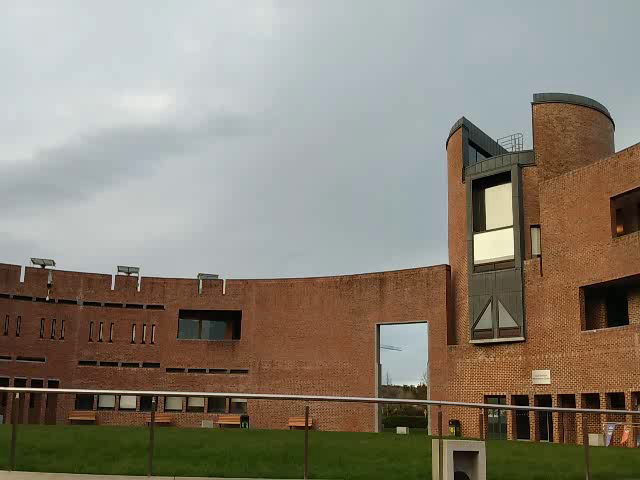

In [ ]:
print("Frame 0")
f0 = cv2.imread('/content/frame_0.png')
cv2_imshow(f0)

Frame 1


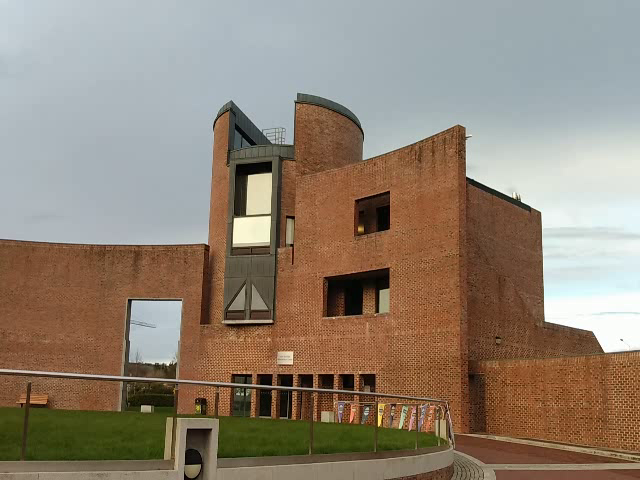

In [ ]:
print("Frame 1")
f1 = cv2.imread('/content/frame_1.png')
cv2_imshow(f1)

Frame 2


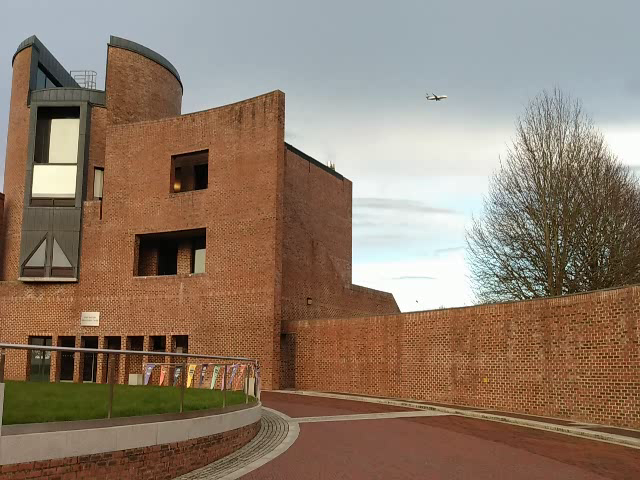

In [ ]:
print("Frame 2")
f2 = cv2.imread('/content/frame_2.png')
cv2_imshow(f2)

Stitching Image Panoramas


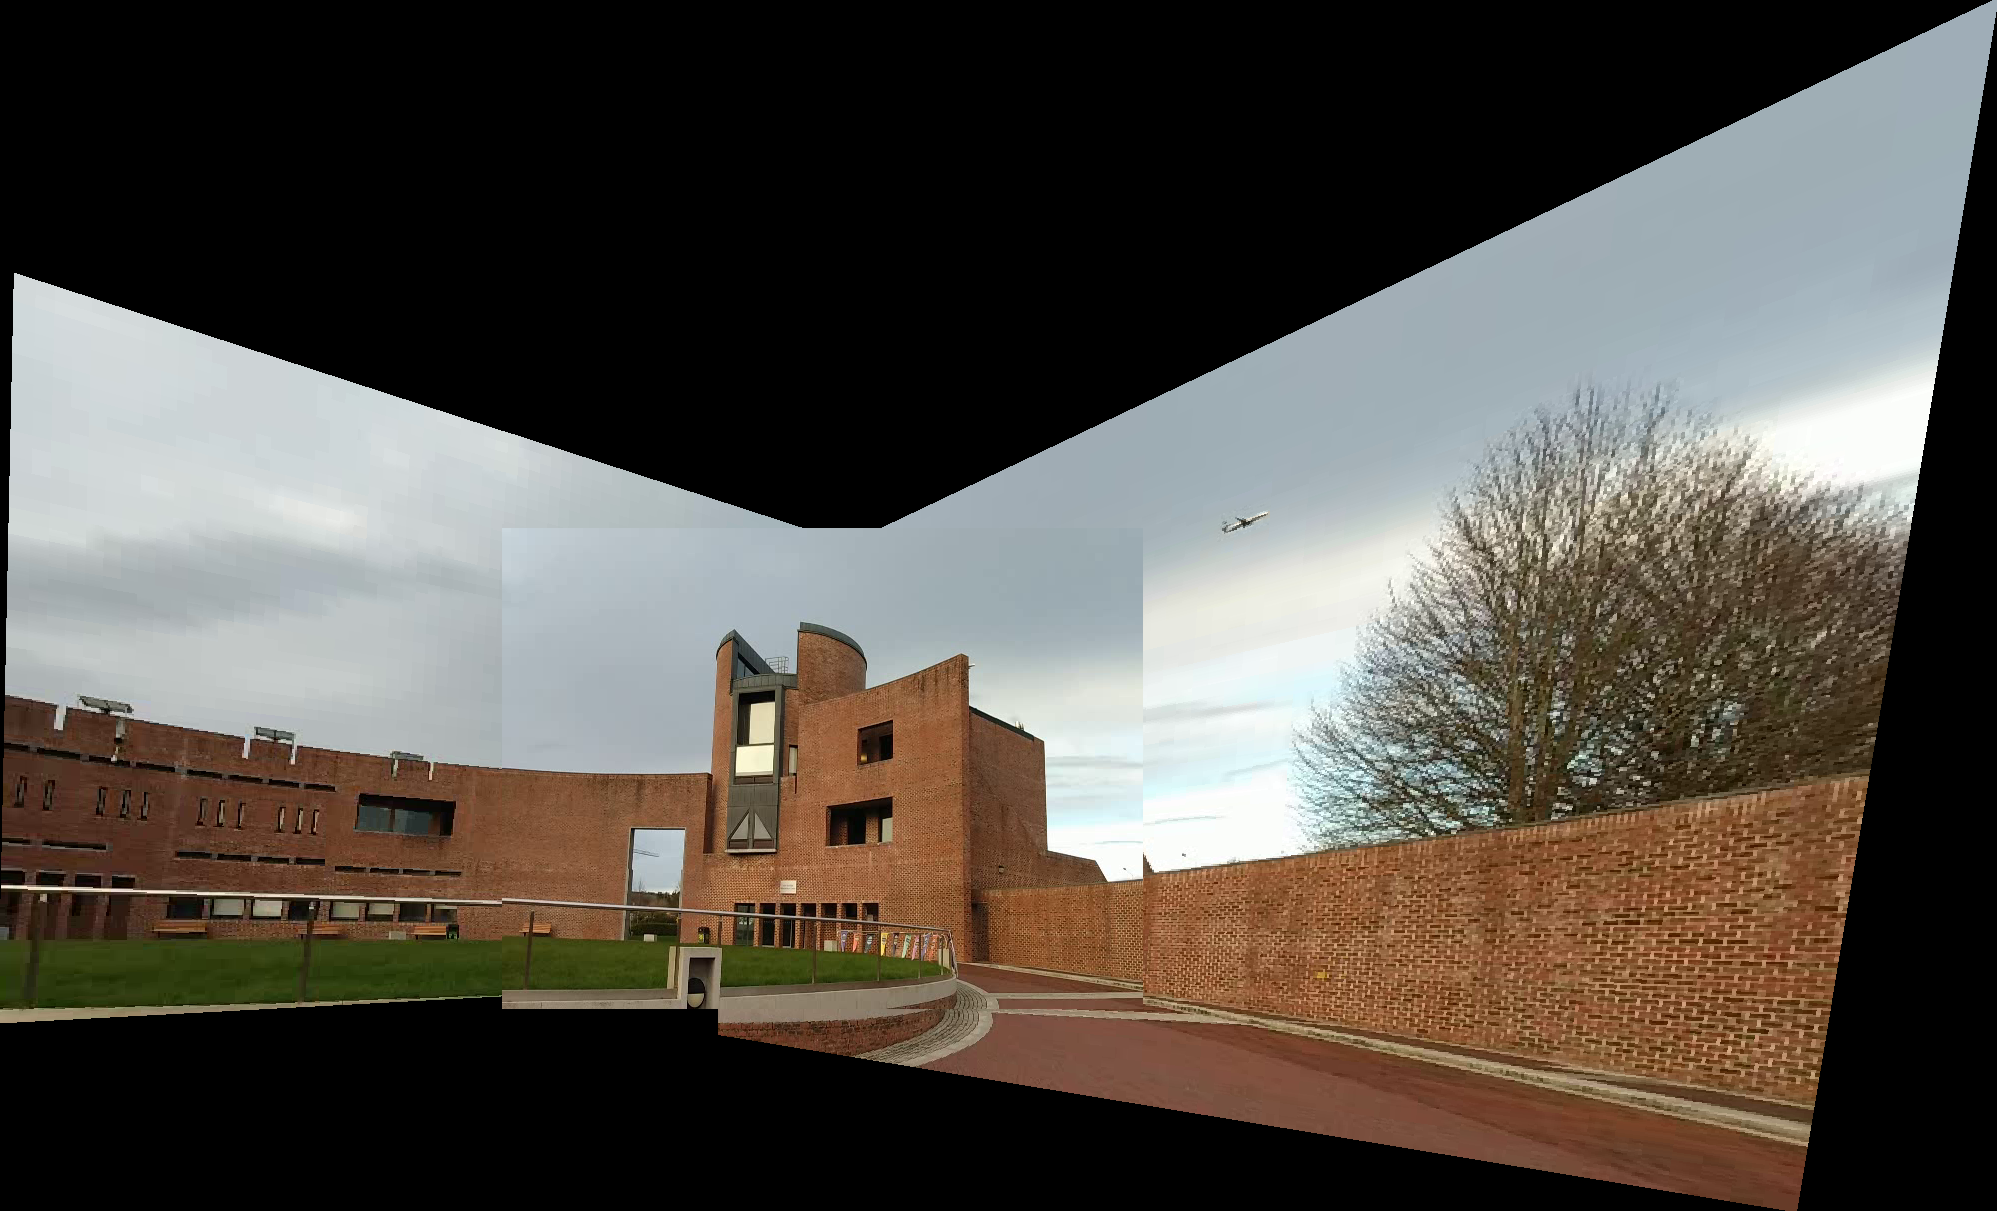

In [ ]:
print("Stitching Image Panoramas")
pano = cv2.imread('/content/stitching_result.png')
cv2_imshow(pano)